# PSTAT 134 Final Project: The Yelp Dataset

## 1 Introduction

### 1.1 Preparing the Environment

In [151]:
import json
import os
import cv2
import shutil
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
# image processing
import matplotlib.image as mpimg
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D 
from keras.layers import Activation, Dropout, Flatten, Dense 
from keras import backend as K
from keras.optimizers import Adam, SGD
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### 1.2 Downloading the Dataset

In [ ]:
# install kaggle API
!pip install kaggle

In [ ]:
# previously created kaggle API key in order to access datasets, yields kaggle.json
# make sure kaggle.json is in users/candacemckeag/.kaggle

In [ ]:
# make API key not readable to other users
# !chmod 600 /Users/candacemckeag/.kaggle/kaggle.json

In [ ]:
# download and unzip the yelp-dataset kaggle files
!kaggle datasets download yelp-dataset/yelp-dataset -p /Users/candacemckeag/Documents/School/134 --unzip

In [ ]:
# had to manually download photos dataset from yelp website

### 1.2 Formatting the Dataset

#### 1.2.1 Reviews

In [ ]:
# read json reviews file
reviews = []
with open('yelp_academic_dataset_review.json') as json_review:
    for line in json_review:
        reviews.append(json.loads(line))

In [ ]:
reviews = json_normalize(reviews)    

In [ ]:
reviews.head()

#### 1.2.2 Photos

In [159]:
# read json photos file
photo_descs = []
with open('yelp_photos/photo.json') as json_photo:
    for line in json_photo:
        photo_descs.append(json.loads(line))

# to dataframe
photo_descs = json_normalize(photo_descs)

In [160]:
# training set
food_train = photo_descs.loc[photo_descs['photo_id'].isin([f.replace('.jpg','') for f in os.listdir('projdata/train/food')])].reset_index()
outside_train = photo_descs.loc[photo_descs['photo_id'].isin([f.replace('.jpg','') for f in os.listdir('projdata/train/outside')])].reset_index()
train = pd.concat([food_train,outside_train]).drop(['index'],axis=1)

In [161]:
# testing sets
food_test = photo_descs.loc[(photo_descs['label']=='food') & (photo_descs['photo_id'].isin([f.replace('.jpg','') for f in os.listdir('projdata/test/food')]))].reset_index()
outside_test = photo_descs.loc[(photo_descs['label']=='outside') & (photo_descs['photo_id'].isin([f.replace('.jpg','') for f in os.listdir('projdata/test/outside')]))].reset_index()
test = pd.concat([food_test,outside_test]).drop(['index'],axis=1)

In [162]:
# load training images
filelist = ['projdata/train/food'+'/'+nm+'.jpg' for nm in food_train['photo_id']] + ['projdata/train/outside'+'/'+nm+'.jpg' for nm in outside_train['photo_id']]
train_image = []
for i in range(len(filelist)):
    image = Image.open(filelist[i])
    image = image.resize((150,150))
    image = img_to_array(image)
    train_image.append(image)
train_labels = train['label']

# load testing images
filelist_ts = ['projdata/test/food'+'/'+nm+'.jpg' for nm in food_test['photo_id']] + ['projdata/test/outside'+'/'+nm+'.jpg' for nm in outside_test['photo_id']]
test_image = []
for i in range(len(filelist_ts)):
    image = Image.open(filelist_ts[i])
    image = image.resize((150,150))
    image = img_to_array(image)
    test_image.append(image)
test_labels = test['label']

## 2 Exploratory Data Analysis

## 3 Text Mining

## 4 Convolutional Neural Network Image Classification

We now build an image classification model using the Keras API. Keras is a high-level neural networks and deep learning library available in Python. ...

Before we get into the image modeling, we scale the raw pixel intensities originally between 0 and 255 to range from 0 to 1.

In [163]:
# scale the raw pixel intensities to the range [0, 1]
train_image_scl = []
for arr in train_image:
    train_image_scl.append(np.array(arr, dtype="float") /255.0 )

test_image_scl = []
for arr in test_image:
    test_image_scl.append(np.array(arr, dtype="float") /255.0 )

### 4.1 Data Augmentation

In order to make the most of the training examples and provide the model with as much predictive power as possible, we "augment" them by using random transformations. This ensures that the model never sees the exact same picture twice and also helps prevent overfitting by improving generalizability. The function used generates batches of tensor image data with real-time data augmentation. 

As an example, we define a data generator.

In [164]:
# data augmentation
# enabling us to generate “additional” training data by randomly transforming the input images
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        # rescaling image like prior step
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

Using this data generator, we will transform one picture from the list of training images using the specified transformations. This code creates about forty versions of the original photo.

In [165]:
# perform transformations
i=0
for batch in datagen.flow(train_image_scl[10].reshape((1,) + train_image_scl[10].shape), batch_size=1,
                          save_to_dir='projdata', save_prefix='DAex', save_format='jpeg'):
    i += 1
    if i > 20:
        # prevent infinite loop
        break
# open images that were just created
DApics = []
for i in os.listdir('projdata'):
    if os.path.isfile(os.path.join('projdata',i)) and 'DAex' in i:
        DApics.append(Image.open('projdata'+'/'+i))

Now that we have created and opened these transformed images, we can plot them to see how they differ from one another.

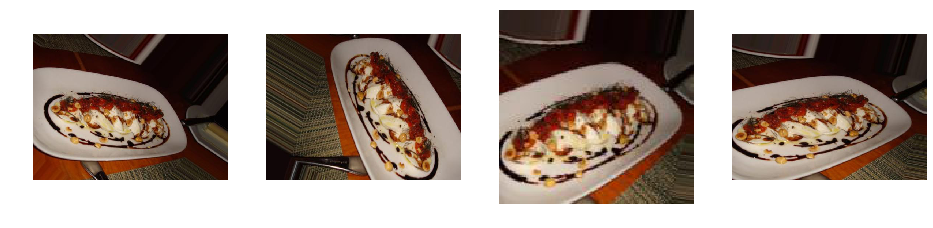

In [166]:
fig = plt.figure(figsize=(16,16))
image1 = plt.subplot(141)
image2 = plt.subplot(142)
image3 = plt.subplot(143)
image4 = plt.subplot(144)
_ = image1.imshow(DApics[0])
_ = image2.imshow(DApics[1])
_ = image3.imshow(DApics[2])
_ = image4.imshow(DApics[3])
image1.axis("off")
image2.axis("off")
image3.axis("off")
image4.axis("off")
plt.show()

As we can see, the images clearly originate from the same photo, but are characterized by a variety of length and width shifts, flips, and stretches. 

### 4.2 Sequential Model

A sequential model is defined as a linear stack of layers. These layers consist of an input layer, an output layer, and usually multiple hidden layers.

In [167]:
# initialize the number of epochs to train for, initial learning rate,
# and batch size
EPOCHS = 25
INIT_LR = 1e-3
BS = 32

In [168]:
model = Sequential()
# model needs to know what inputShape to expect
inputShape = (150, 150, 3)
# first set of CONV => RELU => POOL layers
model.add(Conv2D(20, (5, 5), padding="same", input_shape=inputShape))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# second set of CONV => RELU => POOL layers
model.add(Conv2D(50, (5, 5), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# first (and only) set of FC => RELU layers
model.add(Flatten())
model.add(Dense(500))
model.add(Activation("relu"))
 
# softmax classifier
# Dense supports the specification of its input shape 
model.add(Dense(2))
model.add(Activation("softmax"))

In [169]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

In [170]:
# this is a generator that will read pictures found in
# subfolders of 'projdata/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'projdata/train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=BS,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

Found 2172 images belonging to 2 classes.


In [171]:
# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'projdata/test',
        target_size=(150, 150),
        batch_size=BS,
        class_mode='categorical')

Found 1092 images belonging to 2 classes.


Finally, before fitting the model we initialize our optimizer, loss function, and evaluation metric. We will be using the Adam optimizer, which is an extension to stochastic gradient descent that computes individual adaptive learning rates for different parameters from estimates of first and second moments of the gradients. For a loss function we use categorical crossentropy which measures the performance of a classification model whose output is a probability value between 0 and 1. Our evaluation metric is simply accuracy, which is the percent of correct predictions the model makes.

In [174]:
# initialize
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

In [176]:
H = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_image_scl) // BS,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=len(validation_generator) // BS)

Epoch 1/10
67/67 [==============================] - 140s 2s/step - loss: 0.3264 - acc: 0.8764 - val_loss: 0.2195 - val_acc: 0.9062
Epoch 2/10
67/67 [==============================] - 156s 2s/step - loss: 0.2813 - acc: 0.9011 - val_loss: 0.2683 - val_acc: 0.8750
Epoch 3/10
44/67 [==================>...........] - ETA: 42s - loss: 0.2381 - acc: 0.9041

KeyboardInterrupt: 

## 5 Conclusion

## 6 References

* *Image classification with Keras and deep learning* by Adrian Rosebrock, https://www.pyimagesearch.com/2017/12/11/image-classification-with-keras-and-deep-learning/
* *Building powerful image classification models using very little data* by Francois Chollet, https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
* *Gentle Introduction to the Adam Optimization Algorithm for Deep Learning* by Jason Brownlee, https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/